# 8. Introduction to MCMC

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/08-intro-to-mcmc.ipynb)

**Date**: Wednesday Sept 11, 2024

## LEARNING OUTCOMES
- Understand the components of a MCMC (Markov chain Monte Carlo) algorithm and some common MCMC algorithms
- Use the MCMC toolset that `gemlib` provides to run the Metropolis-Hastings algorithm on simulated data from a SIR model to estimate the parameters

## Introduction

In this notebook, we simulate data from a homogeneously mixing stochastic SIR model, and then use the inference tools in `gemlib` to estimate the transmission rate and recovery rate parameters.

## MCMC theory

### What is MCMC?

- Class of algorithms used to draw samples from a probability distribution, known as the target or posterior distribution – which we specify with the likelihood and prior distribution(s)
- Goal is to perform probabilistic inference to find parameter values (and sometimes missing data)
- MCMC methods are used to infer probability distributions that are too high dimensional or complex to be estimated solely with analytical methods
- Algorithms produce Markov chains and are constructed in such a way that the stationary distribution of these Markov chains is equal to the posterior distribution. This means that provided the algorithms are run long enough, they will draw samples from the posterior distribution.
- Advantage: Overcome the inefficiency of rejection sampling in high dimensions (due to the _curse of dimensionality_ – exponential increase in probability of rejection as number of dimensions increases) by staying in regions of high probability if already there
- Disadvantage: Do so at the expense of independent samples (samples are autocorrelated, so need more samples to get as good an estimate of the posterior distribution)

### Components of a MCMC algorithm:
There are three main components of a MCMC algorithm:
- proposal distribution
- acceptance probability calculation
- accept/reject step

### Common algorithms



#### Metropolis-Hastings
- The canonical MCMC algorithm
- Consists of repeating the following steps many times:
  1. Propose a new value of the parameter based on the current value.
  2. Calculate the ratio of the posterior probability of the data given this value to that given the current value (the acceptance probability).
  3. Accept/reject the proposed value with probability equal to the acceptance probability.

**Metropolis-Hastings (MH) algorithm:**
1. Start from some initial value $\theta^{(0)}$ (e.g. drawn from the prior distribution $\pi_0(\theta)$
2. Propose a new value $\theta'$ from the proposal distribution $q(\theta'|\theta^{(i)})$
3. Calculate the acceptance probability:

$$
\alpha=\min\left(1,\frac{\pi(\theta'|y)}{\pi(\theta^{(i)}|y)}\frac{q(\theta^{(i)}|\theta')}{q(\theta'|\theta^{(i)})}\right)
$$

where $\pi(\theta|y)\propto L(\theta;y)\pi_0(\theta)$ is the posterior distribution, and $L(\theta;y)=f(y|\theta)$ is the likelihood of observing the data $y$ given the parameters $\theta$
4. Set $\theta^{(i+1)}=\theta$ with probability $\alpha$, otherwise set $\theta^{(i+1)}=\theta^{(i)}$
5. Repeat the above steps $K$ times

- Need to write down the likelihood of the model (see earlier sessions).
- Have to pick prior distributions for parameters, which should reflect your prior beliefs/knowledge about their values. Many possibilities.
- Proposal distribution can be symmetric (e.g., Normal distribution) or asymmetric. When it's symmetric, algorithm is known as random walk Metropolis (RWM).
- In multiple dimensions, you can update one parameter at a time (single-site or single-component updates) or update multiple parameters together (multi-site or block updates), e.g., with a multivariate Normal proposal distribution with a suitably chosen covariance matrix.
- Need to tune the variance of the proposal distribution, which determines how big the jump between the current value and the proposed value is, to ensure that the chain *mixes* well.
- Need to run the chain long enough that it has *converged* and samples are being drawn from the posterior distribution.
- Issues:
  - Samples are autocorrelated, and the effective sample size (ESS) (equivalent number of independent samples) may be much lower than the number of samples taken.
  - The Markov chain eventually converges to the correct distribution, but it may take a long time to do so, and initial samples typically follow a different distribution, especially if the chain is started in a low-probability region. So a *burn-in* period is needed, and the samples from this period need to be discarded.
  - Tends to also suffer from the curse of dimensionality as the number of dimensions increases.
- These issues can, to some extent, be tackled by running the chain for longer, thinning (only taking every Xth sample), and using techniques like adaptive tuning of the proposal (co)variance.

#### Gibbs sampler
- An algorithm for sampling from a multidimensional probability distribution, $\pi(\theta|y)$ where $\theta=(\theta_1,\dots,\theta_n)$, when sampling from the joint distribution is difficult but sampling from the conditional distributions, $\pi(\theta_j|\theta_{-j},y)$ where $\theta_{-j}=(\theta_1,\dots,\theta_{j-1},\theta_{j+1},\dots,\theta_n)$, is more straightforward.
- The sequence of samples drawn from the conditional distributions can be used to approximate the joint posterior distribution, or marginal distributions, or expected value of some function of the parameters/missing data.
- Consists of drawing a sequence of samples by sampling in turn from each of the conditional distributions of the parameters given the current values of the other parameters.
- It is a special case of the Metropolis-Hastings algorithm in which the proposal is always accepted.

- **Gibbs sampler algorithm:**
  1. Start with some initial value of the parameter vector $\theta^{(0)}=(\theta_1^{(0)},\dots,\theta_j^{(0)},\dots,\theta_n^{(0)})$
  2. Draw $\theta_j^{(i+1)}\sim\pi(\theta_j^{(i+1)}|\theta_1^{(i+1)},\dots,\theta_{j-1}^{i+1},\theta_{j+1}^{(i)},\dots,\theta_n^{(i)},y)$
  3. Repeat the above steps $K$ times

#### Hamiltonian Monte Carlo (HMC)
- HMC is a gradient-based MCMC algorithm that uses the gradient of the log posterior and Hamiltonian dynamics to propose new points in the parameter space.
- It helps to overcome some of the issues of the M-H algorithm such as:
  - the difficulty of tuning the proposal variance in high dimensions
  - slow convergence in high dimensions
  - inefficient exploration of the parameter space, particularly in high dimensions
- It is implemented in Stan and TensorFlow but we will not cover its use in this course.

#### Metropolis-within-Gibbs (MwG)
- The MwG algorithm is essentially a generalisation of the Gibbs sampler that allows parameter updates made with Gibbs steps to be replaced by Metropolis-Hastings steps.
- It is used in the scenario in which it is no longer straightforward to sample some parameters directly from their conditional posterior distributions, but it is possible to update them with a M-H step.
-  It is particularly useful in the context of data augmentation MCMC (DA-MCMC), where it may be possible to draw the parameters from their conditional posterior distribution $\pi(\theta|X,y)$ using a Gibbs step, but it is not straightforward to draw the missing data $X$ from its conditional distribution $\pi(X|\theta,y)$ as this is typically not available in closed form.


### Exercise 1
Here's a nice [visualisation](https://chi-feng.github.io/mcmc-demo/app.html) of some of these algorithms. Have a play with the different algorithm options and target distributions to see the behaviour and performance of the different algorithms. (You may wish to set the autoplay delay to a smaller value and clink "Reset".)

## MCMC code

### Install `gemlib`

We'll start by installing the `gemlib` library.

In [1]:
from warnings import warn

try:
    import google.colab
    !pip install -Uq gemlib
except:
    warn("Not running in Colab, make sure `gemlib` is installed locally")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 9.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


and now import the modules we need for this notebook...

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from typing import NamedTuple

import tensorflow as tf
import tensorflow_probability as tfp

import gemlib
assert gemlib.__version__ == "0.11.1"
from gemlib.distributions import DiscreteTimeStateTransitionModel

tfd = tfp.distributions

import seaborn as sns

%matplotlib inline

DTYPE=np.float32

sns_c = sns.color_palette(palette = "Dark2")

### The epidemic model

We're going to model our epidemic using a SIR model, where individuals begin as susceptible, become infected, and recover from their infection.

Here, we have 3 _states_: $S$, $I$, and $R$ representing susceptible, infected, and recovered individuals respectively.

We then have two transitions, $S \rightarrow I$ and $I \rightarrow R$, for which we assume transition rates

\begin{align*}
\lambda^{SI} &= \beta I/N + \epsilon \\
\lambda^{IR} &= \gamma
\end{align*}


## Incidence matrix

In [3]:
incidence_matrix = np.array(
    [ #  SI  IR
        [-1,  0],  # S
        [ 1, -1],  # I
        [ 0,  1],  # R
    ],
    dtype=DTYPE
)

### Initial state

In [4]:
popsize = 1000

initial_state = np.array([[999, 1, 0],
                          ]).astype(DTYPE)

### Transition rate function

In [5]:
def transition_rates(t, state):
    beta = DTYPE(0.3)
    gamma = DTYPE(0.1)
    epsilon = DTYPE(1e-9)

    si_rate = beta * state[:, 1] / tf.reduce_sum(state) + epsilon

    ir_rate = tf.fill((state.shape[0],), gamma)

    return si_rate, ir_rate

We can check that our transition rate function returns something sensible if supplied the initial state:

In [6]:
test_rates = transition_rates(0.0, initial_state)
print(f"Test rate shapes: {[x.shape for x in test_rates]}")
print(f"Infection rate: {test_rates[0]}")
print(f"Recovery rate: {test_rates[1]}")

Test rate shapes: [TensorShape([1]), TensorShape([1])]
Infection rate: [0.0003]
Recovery rate: [0.1]


### The discrete-time model

Armed with the data structures and functions above, we can now instantiate the `DiscreteTimeStateTransitionModel`

In [7]:
sir = DiscreteTimeStateTransitionModel(transition_rate_fn=transition_rates,
                                       incidence_matrix=incidence_matrix,
                                       initial_state=initial_state,
                                       initial_step=0,
                                       time_delta=1.0,
                                       num_steps=100)

### Exercise 2
Run a simulation using the `sample` method for the `DiscreteTimeStateTransitionModel` and check the shape of the output. What are its dimensions?

In [8]:
# run simulation using `sample` method with seed [0,0]

In [9]:
# plot the number of SI and IR transitions over time

### Solution

In [49]:
sir_sim = sir.sample(seed=[0, 0])
sir_sim.shape

TensorShape([100, 1, 2])

`sample()` spits out a transition events tensor of dimension [T, N, L] for  $T$  timesteps, $N$  metapopulations or individuals (in this case $N = 1$),  and  $L$  transitions. This is a tensor,  $Z$, such that  $z^{qr}_{it}=1$  if individual  $i$ undergoes a transition from $q$ to $r$ at timestep $t$ and $z^{qr}_{it}=0$ otherwise.

We can therefore compute the total number of each type of transition happening on each day by taking the sum across the second dimension (i.e. $N$) of the tensor. In the context of our SIR model this is, of course, equivalent to plotting the daily absolute incidence of infection and recovery events.

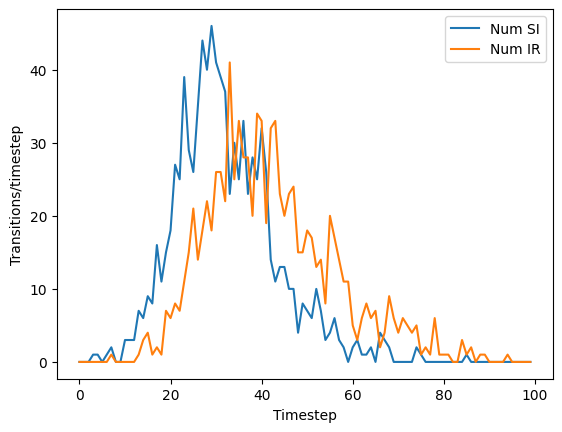

In [50]:
plt.plot(np.sum(sir_sim, axis=1), label=["Num SI", "Num IR"])
plt.xlabel("Timestep")
plt.ylabel("Transitions/timestep")
plt.legend()

To get the number of individuals in each state over time, we can use the `compute_state` method of the `sir` model on our `sir_sim` object

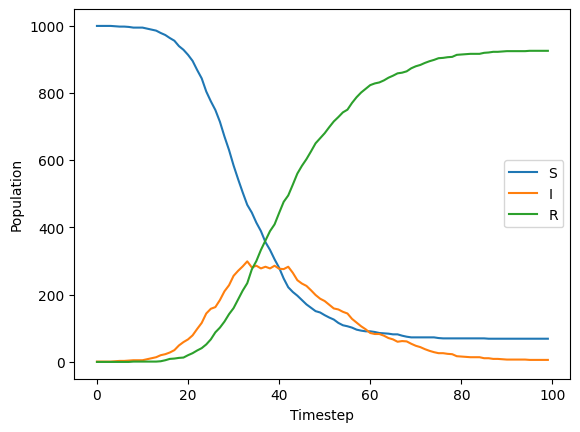

In [51]:
sir_sim_state = sir.compute_state(sir_sim)
plt.plot(np.sum(sir_sim_state, axis=1), label=["S", "I", "R"])
plt.xlabel("Timestep")
plt.ylabel("Population")
_ = plt.legend()

### Using Tensorflow for performance

You may have noticed that the simulation we have run above is not exactly snappy!  Since we're using Tensorflow, we can use the power of either Graph Mode or XLA compilation to accerate it.  All we need to do is wrap the call to `sir.sample()` in a decorated function, i.e. write a function that returns the `sir.sample()` function with a given random seed and put `@tf.function()` or `@tf.function(jit_compile=True)` respectively above the function definition.

### Exercise 3
Have a go at using Graph Mode and XLA compilation and time how long it takes to run a simulation of the SIR model using each. Which is faster? Is this still true if you rerun the XLA-compiled function? Why?

### Solution
Starting with graph mode compilation:

In [11]:
@tf.function()
def run_sir_sample_graph(seed):
    return sir.sample(seed=seed)

%time sir_sim_graph = run_sir_sample_graph(seed=[0,5])

CPU times: user 502 ms, sys: 14.8 ms, total: 517 ms
Wall time: 506 ms


it's quite a bit faster! Now let's try XLA compilation:

In [12]:
@tf.function(jit_compile=True)
def run_sir_sample_xla(seed):
    return sir.sample(seed=seed)

%time sir_sim_xla = run_sir_sample_xla(seed=[0,5])

CPU times: user 12.6 s, sys: 281 ms, total: 12.9 s
Wall time: 13.3 s


That's slower! Let's run it again...

In [13]:
%time sir_sim_xla = run_sir_sample_xla(seed=[0,5])

CPU times: user 3.23 ms, sys: 0 ns, total: 3.23 ms
Wall time: 3.23 ms


That's quicker!  When we first ran our XLA-compiled function, it took time for the compiler to build the machine code required to implement the function.  When we ran it for a second time, the compilation had already been done so all that's left is the runtime.  Try running this notebook again using a GPU runtime, and see if you get any difference in speed...

<a name="log-lik-simple"></a>
### Log-likelihood computation

The last thing in this section that we'll look at is how to compute the probability of obtaining a given timeseries of transition events given the parameters, initial state, and indeed the model.  This is, of course, cruicial for inference, as we describe in the next section.

This is super-easy to compute, just using `DiscreteTimeStateTransitionModel`'s `log_prob` method.

In [14]:
sir.log_prob(sir_sim)

<tf.Tensor: shape=(), dtype=float32, numpy=-369.7207>

## Inference

Now we have a working model (and simulated data), we can use it to construct a Bayesian model by specifying prior distributions for it.

Let our epidemic model be written as

$$
Z \sim \mbox{SIR}(\beta, \gamma, \mathbf{x}_0)
$$

where $Z$ is the output transition events tensor (`sir_sim` above), $\mathbf{x}_0$ is the initial state, and $\theta = \{\beta, \gamma\}$ are the parameters.  We place priors on the parameters such that

\begin{align*}
\beta & \sim \mbox{Gamma}(1.0, 5.0) \\
\gamma & \sim \mbox{Gamma}(1.0, 0.5)
\end{align*}


### Implementing a Bayesian model

To build this model, we essentially have to specify a probabilistic DAG.  In code, we do this by using the TensorFlow Probability `JointDistributionCoroutine` class.  

Notice that I've specified the entire model from scratch.  This is required because if we change the value of a parameter (as an optimiser or MCMC algorith will), then we need to re-instantiate the model with the new parameter value.

* Think about this in terms of the Bayesian DAG, and how we write probability distributions as above, to see why this is sensible.
* It's also computing best practice -- wrapping all the logic into functions guards against unexpected results due to global variables being changed when you're not looking!

In [15]:
Root = tfd.JointDistributionCoroutine.Root

In [16]:
@tfd.JointDistributionCoroutineAutoBatched
def model():

    # Priors
    beta = yield Root(
        tfd.Gamma(
            concentration=DTYPE(1.0), rate=DTYPE(5.0), name="beta"
        )
    )

    gamma = yield Root(
        tfd.Gamma(
            concentration=DTYPE(1.0), rate=DTYPE(0.5), name="gamma"
        )
    )

    # Epidemic model
    incidence_matrix = np.array(
    [ #  SI  IR
        [-1,  0],  # S
        [ 1, -1],  # I
        [ 0,  1],  # R
    ],
    dtype=DTYPE
    )

    popsize = 1000

    initial_state = np.array([[999, 1, 0]]).astype(DTYPE)

    def transition_rates(t, state):
      epsilon = DTYPE(1e-9)

      si_rate = beta * state[:, 1] / tf.reduce_sum(state) + epsilon
      ir_rate = tf.broadcast_to(gamma, si_rate.shape)

      return si_rate, ir_rate

    sir = yield DiscreteTimeStateTransitionModel(transition_rate_fn=transition_rates,
                                       incidence_matrix=incidence_matrix,
                                       initial_state=initial_state,
                                       initial_step=0,
                                       time_delta=1.0,
                                       num_steps=100,
                                       name ="sir")

### Prior simulation

So we now have an instantiated model, but what can we do with it? The first thing we might like to do is to simulate from the _prior_ model.  That is, draw the parameters from their respective prior distributions, plugging the resulting values into the SIR model and then simulating from it.  In other words, we start at the top of the DAG, and work our way downwards.

Given we've set up a `JointDistributionCoroutine`, this is very simple!  We just call the `sample()` method with a seed, and obtain a `StructTuple` of values for each of the distributions in our model.  TFP automatically takes care of drawing from the distributions in the correct order.

In [17]:
prior_sim = model.sample(beta = 0.2, seed=[0,4])


Of course, simulating from the prior distributions is not guaranteed to give us any sensible epidemic simulation output, as there is nothing constraining the parameters to be consistent with the data other than our _a priori_ belief about their values.  Even if we specified carefully chosen marginal prior distributions for the parameters, there is nothing stopping us simulating combinations of parameters that lead to non-sensical epidemic output.  

What we need to do is _condition_ the model on having observed some epidemic output, and then find a way to work out the joint _a posteriori_ distribution of the parameters in the light of these observations.  

Bayes' Theorem tells us that

$$
Pr(\theta | Z, \mathbf{x_0}) = \frac{Pr(Z | \theta, \mathbf{x}_0)Pr(\theta)}{\int_{\Theta} Pr(Z | \theta, \mathbf{x_0})Pr(\theta) \mathrm{d}\theta}
$$

where $Pr(\theta | Z, \mathbf{x}_0)$ is the _posterior distribution_, $Pr(Z | \theta, \mathbf{x}_0)$ is the probability of observing the transition event timeseries $Z$ given the parameters and initial state $\mathbf{x}_0$, i.e. the likelihood, $Pr(\theta)$ is the (joint) prior distribution of the parameters.

In computing, conditioning a model is essentially the same as fixing the value of a given function argument, which TFP allows us to do with the `experimental_pin` method.

### Exercise 4
Condition the model on the simulated epidemic `sir_sim` from above and use the conditioned model to calculate the log-probability of the simulated data for $\beta=0.2$ and $\gamma=0.02$.

### Solution

In [18]:
conditioned_model = model.experimental_pin(sir=sir_sim)

In [19]:
conditioned_model.log_prob(beta=0.2, gamma=0.02)

<tf.Tensor: shape=(), dtype=float32, numpy=-1188.5748>

The fact that we know this distribution only up to a constant is the reason we employ methods such as MCMC to draw samples from, and hence estimate, posterior distributions in all but the simplest of cases.  Readers are referred to the following texts for an in-depth discussion of these foundational principles:

* Gilks, W., Richardson, S., Spiegelhalter, D. (1995). Markov Chain Monte Carlo in Practice. Taylor & Francis. ISBN: 9780412055515
* Gelman, A., Carlin, J.B., Stern, H.S., Dunson, D.B., Vehtari, A., & Rubin, D.B. (2013). Bayesian Data Analysis (3rd ed.). Chapman and Hall/CRC. https://doi.org/10.1201/b16018

## Parameter inference

In this section, we'll use TFP to build an MCMC sampler to sample from the _joint posterior distribution_ of the parameters assuming that the transition event timeseries is fully known.

### MCMC

In [20]:
# construct RWM kernel
kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn = conditioned_model.log_prob,
    new_state_fn = tfp.mcmc.random_walk_normal_fn(
        scale=0.01,
        name='Proposal'
    )
)

In [21]:
# Wrap a sample function for XLA compilation
@tf.function(jit_compile=True)
def sample_chain(num_results, current_state, kernel, seed=[0,0]):
    return tfp.mcmc.sample_chain(
        num_results = num_results,
        current_state = current_state,
        kernel = kernel,
        seed = seed
)

In [22]:
# set number of iterations
num_iterations = 10000

In [23]:
# sample chain and store results
samples, results = sample_chain(
    num_results = num_iterations,
    current_state = conditioned_model.sample_unpinned(seed=[0,1]),
    kernel = kernel,
    seed = [0,2],
)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [24]:
def trace_plot(samples):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # if not isinstance(samples, list):
    #     samples = [samples]
    if np.ndim(samples.beta)==1:
        # beta
        ax[0].plot(samples.beta, linewidth=1)
        # gamma
        ax[1].plot(samples.gamma, linewidth=1)
    else:
        # trace plots for parameters
        for i in range(num_chains):
            # beta
            ax[0].plot(samples.beta[:,i], color=sns_c[i], linewidth=1, alpha=0.3, label = 'Chain '+str(i))
            # gamma
            ax[1].plot(samples.gamma[:,i], color=sns_c[i], linewidth=1, alpha=0.3, label = 'Chain '+str(i))
        # legend
        handles, labels = ax[1].get_legend_handles_labels()
        fig.legend(handles, labels, loc=5, bbox_to_anchor=(1.2, 0.5), title="Chain")

    # subtitles
    ax[0].set_title('Trace plot of beta')
    ax[1].set_title('Trace plot of gamma')

    # axis limits
    # ax[0].set_ylim(0., 0.4)
    ax[1].set_ylim(0., 0.2)

    # true value lines
    ax[0].hlines(xmin=0, xmax=samples.beta.shape[0], y=0.3, color="red")
    ax[1].hlines(xmin=0, xmax=samples.beta.shape[0], y=0.1, color="red")

    # plot level axis labels
    ax[0].set_xlabel("Iteration")
    ax[1].set_xlabel('Iteration')
    fig.text(0.04, 0.5, 'Parameter Value', va='center', rotation='vertical')

    plt.show()

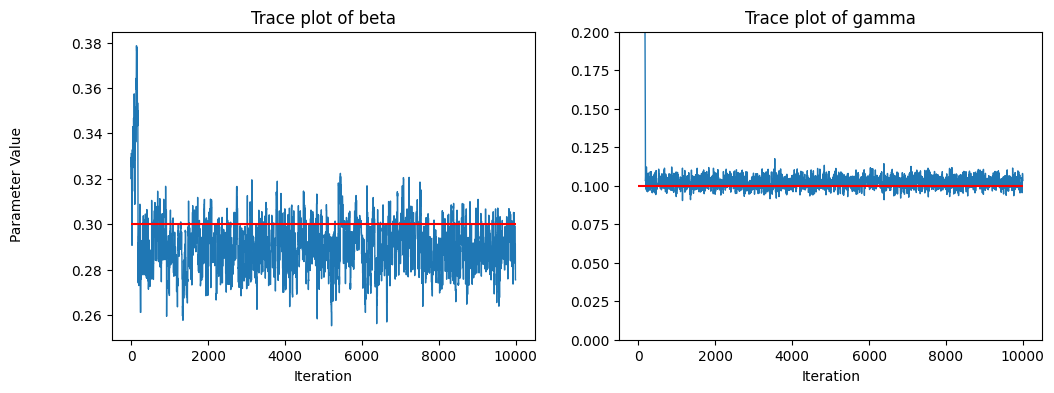

In [25]:
trace_plot(samples)

# 9. MCMC diagnostics


## LEARNING OUTCOMES
- Understand and implement different MCMC diagnostics for assessing convergence and mixing of MCMC chains
- Learn to diagnose what is wrong from MCMC output and know what to change to fix it

## Introduction
Two "issues" with MCMC are that:
- it can take a long time for the chain to reach the high posterior density part of the parameter space and produce samples from the posterior distribution (which relates to  the _convergence_ of the MCMC chain to its stationary distribution)
- it does not produce independent samples from the posterior distribution (which relates to what we call the _mixing_ of the MCMC chain)

What we would like is for the chain to have converged, so that we're sampling from the posterior distribution, and for the samples to be as close to independent as possible. When the samples are close to uncorrelated, we say the chain is _mixing well_. To achieve this we need to tune the proposal variance for the jumps at each iteration, so that the parameter space is explored as efficiently as possible (i.e. we make as big jumps as possible without jumping out of the high posterior density region too often).

## Visual

### Trace plots
The first visual diagnostic we can use to check if the chain is mixing well are trace plots.

- stepped trace plots suggest the proposal variance is too large (most proposals are jumping out of the high probability density region and hence being rejected)
- meandering/snaking trace plots suggest high autocorrelation between samples and proposal variance is too small

E.g. if we rerun the random walk Metropolis algorithm above with a larger proposal variance:

In [26]:
# construct RWM kernel
kernel_large = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn = conditioned_model.log_prob,
    new_state_fn = tfp.mcmc.random_walk_normal_fn(
        scale=0.1,
        name='Proposal'
    )
)

In [27]:
# sample chain and store results
samples_large, results_large = sample_chain(
    num_results = num_iterations,
    current_state = conditioned_model.sample_unpinned(seed=[0,1]),
    kernel = kernel_large,
    seed = [0,2],
)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


and plot the trace plots

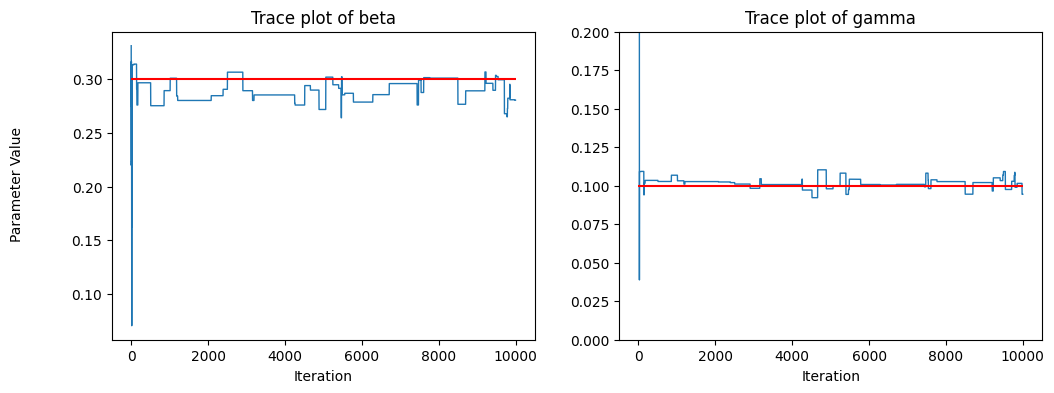

In [28]:
trace_plot(samples_large)

we see that they look very stepped.

### Exercise 1
Rerun the RWM with a smaller proposal variance, e.g. `scale=0.001`, and plot the traces for the parameters. What do you observe?

In [ ]:
# construct RWM kernel

In [ ]:
# sample chain and store results

In [ ]:
# plot the trace plots

### Solution

In [33]:
# construct RWM kernel
kernel_small = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn = conditioned_model.log_prob,
    new_state_fn = tfp.mcmc.random_walk_normal_fn(
        scale=0.001,
        name='Proposal'
    )
)

In [34]:
# sample chain and store results
samples_small, results_small = sample_chain(
    num_results = num_iterations,
    current_state = conditioned_model.sample_unpinned(seed=[0,1]),
    kernel = kernel_small,
    seed = [0,2],
)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


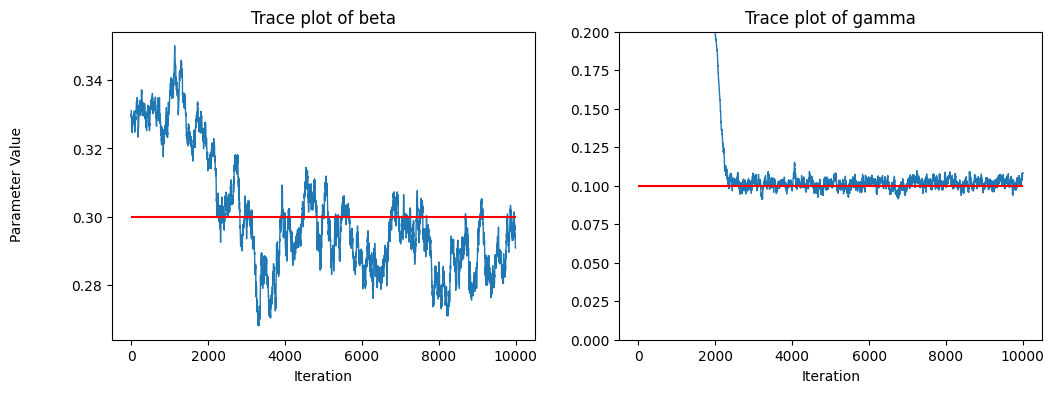

In [35]:
trace_plot(samples_small)

we see that the chain both takes longer to converge and once converged wanders about the true value.



If the proposal variance is set correctly the trace plot should oscillate up and down quickly and look like a "hairy caterpillar":

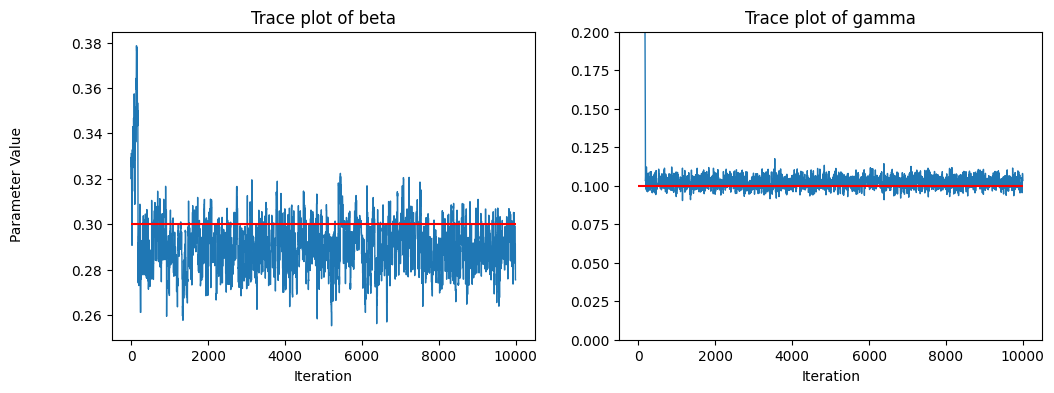

In [36]:
trace_plot(samples)

### ACF plots

Autocorrelation function (ACF) plots can also tell us how well the chain is mixing.

They show the correlation between values in the MCMC chain at different lags. The shaded region on the plot shows the 95% CI for the autocorrelation under the null hypothesis that there is no autocorrelation beyond the corresponding lag, i.e. where the autocorrelation can be considered statistically significant if it falls outside this region.

If the autocorrelation decreases quickly into the shaded region with increasing lags, the chain is mixing well.

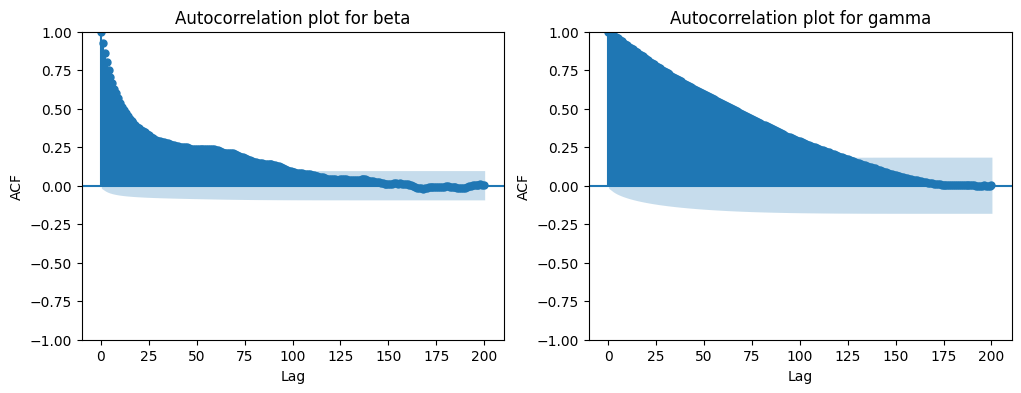

In [37]:
from statsmodels.graphics.tsaplots import plot_acf

def acf_plot(samples):
    # acf plots for parameters
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    # beta
    _ = plot_acf(samples.beta, ax=ax[0], lags=200)
    ax[0].set_title('Autocorrelation plot for beta')
    ax[0].set_xlabel('Lag')
    ax[0].set_ylabel('ACF')
    # gamma
    _ = plot_acf(samples.gamma, ax=ax[1], lags=200)
    ax[1].set_title('Autocorrelation plot for gamma')
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('ACF')

acf_plot(samples)

These plots tell us that approximately every 120th sample in the chain is independent with a proposal standard deviation of 0.01.

We can see that the samples in the chain with the smaller proposal variance are much more strongly autocorrelated:

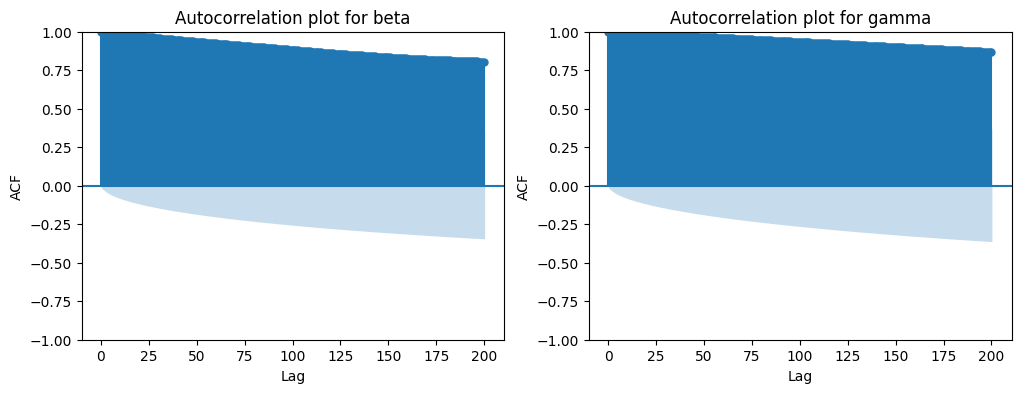

In [38]:
acf_plot(samples_small)

### Exercise 2
Plot the ACF plots for the chain with the larger proposal variance. What do you see? What does this suggest?

In [ ]:
# plot the ACF for samples_large

### Solution

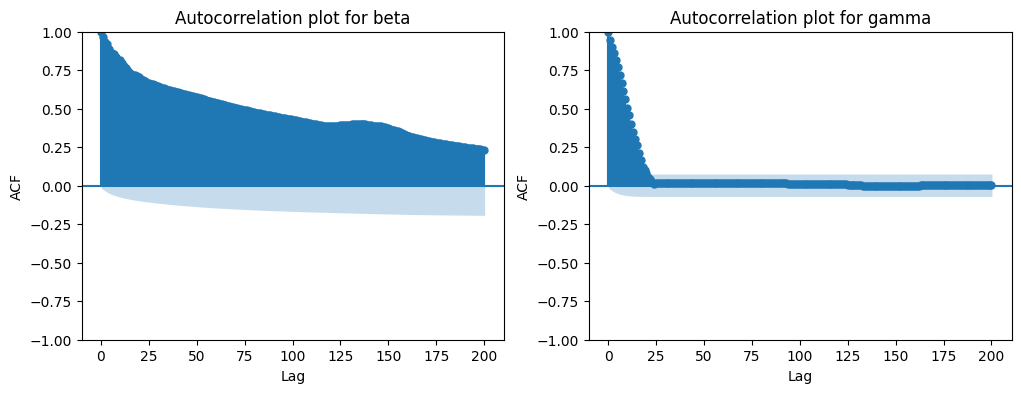

In [39]:
acf_plot(samples_large)

The autocorrelation for $\gamma$ reduces much more quickly than that for $\beta$ and faster than with the original proposal variance, suggesting that the smaller proposal variance for $\gamma$ (with `scale=0.001`) is better than the original proposal variance (with `scale=0.01`).

### Multiple chains
To be confident that the chain has converged it is a good idea to:
- run multiple chains started from different points in the parameter space
- check that they all end up around the same value

Let's run 4 different chains from different starting points with different random number seeds:

In [40]:
num_chains = 4
initial_state = conditioned_model.sample_unpinned(num_chains, seed=[0,7])

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:87: UserWarning: Saw Tensor seed [0, 7], implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  warnings.warn(


In [41]:
chains_samples, chains_results = sample_chain(
        num_results=num_iterations,
        current_state=initial_state,
        kernel = kernel,
        seed = [0,2]
)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


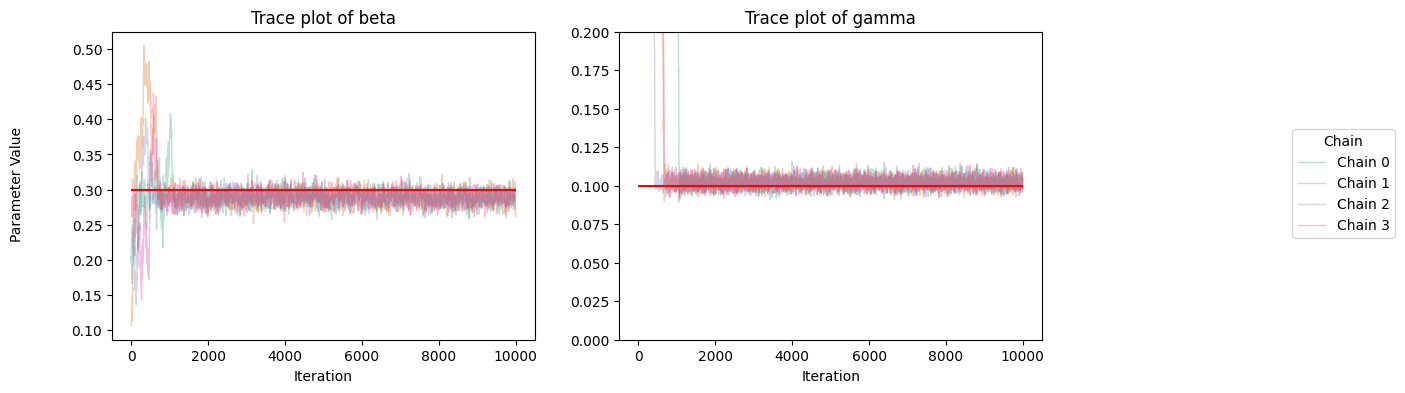

In [42]:
trace_plot(chains_samples)

We can see that all the chains converge to the same values.

### Posterior predictive checks

We pick some posterior samples for the parameters with which to simulate the model

In [108]:
samples_sim = (samples.beta[1000:10000:100],samples.gamma[1000:10000:100])

and repeat each sample 10 times, so that we'll get 10 simulations for each sample

In [110]:
beta_samples = tf.repeat(samples_sim[0],10)
gamma_samples = tf.repeat(samples_sim[1],10)

then run the simulations

In [112]:
posterior_sim = model.sample(beta=beta_samples, gamma=gamma_samples)

This gives us a tensor the size of whose first dimension is the number of $(\beta,\gamma)$ samples, and the size whose remaining dimensions are those of the transition events tensor.

In [120]:
posterior_sim.sir.shape

TensorShape([900, 100, 1, 2])

We convert this to the state tensor as previously

In [46]:
posterior_sim_state = sir.compute_state(posterior_sim.sir)

We can find the median and 95% credible interval of the simulations using the `np.quantile` function:

In [115]:
q_posterior_sim_state = np.quantile(posterior_sim_state, [0.025,0.5,0.975], axis=0)

and plot the output

<ipython-input-116-c7fdae0b7a2d>:13: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(handles=plot_handles,


Text(0, 0.5, 'Population')

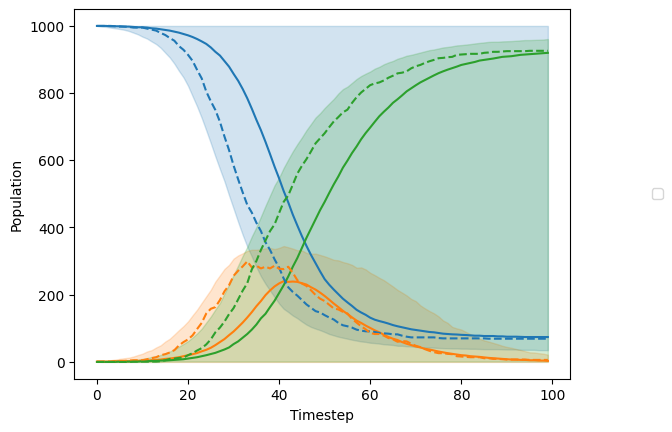

In [116]:
x = range(q_posterior_sim_state.shape[1])
S_line = plt.plot(np.sum(q_posterior_sim_state[1,:,:,0], axis = 1), color='#1f77b4')
plt.fill_between(x,q_posterior_sim_state[0,:,0,0], q_posterior_sim_state[2,:,0,0], alpha=0.2, color='#1f77b4')
I_line = plt.plot(np.sum(q_posterior_sim_state[1,:,:,1], axis = 1), color='#ff7f0e')
plt.fill_between(x,q_posterior_sim_state[0,:,0,1], q_posterior_sim_state[2,:,0,1], alpha=0.2, color='#ff7f0e')
R_line = plt.plot(np.sum(q_posterior_sim_state[1,:,:,2], axis = 1), color='#2ca02c')
plt.fill_between(x,q_posterior_sim_state[0,:,0,2], q_posterior_sim_state[2,:,0,2], alpha=0.2, color='#2ca02c')
plt.plot(np.sum(sir_sim_state, axis=1), linestyle="dashed")

plot_handles = [S_line, I_line, R_line]

# Generate legend using handles and labels
plt.legend(handles=plot_handles,
           labels=["S", "I", "R"],
           loc=5, bbox_to_anchor=(1.2,0.5))

plt.xlabel("Timestep")
plt.ylabel("Population")

### Exercise 3
Why do you think the upper bound of the 95% credible interval for the number of susceptibles is the total population size?

## Numerical

### Acceptance rate
We can check the acceptance rate to make sure it's not too high but also not too low, so that the chain is efficiently exploring the parameter space. There is some theory that tells us that the optimal acceptance rate for mixing of the random walk Metropolis algorithm in 1D is 0.44 and in multiple dimensions when the posterior distribution is approximately multivariate normal is 0.234 [[1](https://doi.org/10.1214/aoap/1034625254),[2](https://doi.org/10.3150/08-BEJ176)].

For the original MCMC run we get:

In [ ]:
acc_rate = np.sum(results.is_accepted)/num_iterations
acc_rate

0.3069

while for the runs with larger and smaller proposal variances we get much lower and higher acceptance rates respectively:

In [ ]:
acc_rate_large = np.sum(results_large.is_accepted)/num_iterations
print(acc_rate_large)
acc_rate_small = np.sum(results_small.is_accepted)/num_iterations
print(acc_rate_small)

0.0067
0.8195


### Effective sample size
Effective sample size (ESS) is the number of independent samples that the autocorrelated MCMC samples are equivalent to.

For a quantity estimated from the posterior distribution, it is the number of independent identically distributed samples that would lead to the same variance in this quantity as that obtained from the chain.

Formally it is defined as:

$$
\mathrm{ESS} = \frac{n}{1+\sum_{k=1}^\infty \rho_k}
$$

where $n$ is the number of MCMC iterations and $\rho_k$ is the lag-$k$ autocorrelation for the samples in the chain. If there were no autocorrelation between the samples ($\rho_k=0, \forall k$) then the ESS would be equal to the number of iterations.

We are looking for as high ESS as possible.

Calculating ESS for the original chain we get:

In [ ]:
ess = tfp.mcmc.effective_sample_size(samples)
ess

StructTuple(
  beta=<tf.Tensor: shape=(), dtype=float32, numpy=157.85603>,
  gamma=<tf.Tensor: shape=(), dtype=float32, numpy=70.69565>
)

and for the runs with larger and smaller proposal variance we get mostly lower values:

In [129]:
ess_large = tfp.mcmc.effective_sample_size(samples_large)
print(ess_large)

StructTuple(
  beta=<tf.Tensor: shape=(), dtype=float32, numpy=42.680603>,
  gamma=<tf.Tensor: shape=(), dtype=float32, numpy=414.15314>
)


The fact that the ESS for $\gamma$ for the run with the larger proposal variance is larger than for the original run suggests that we could perhaps improve the mixing of the chain by using different proposal variances for $\beta$ and $\gamma$, rather than the same proposal variance for both as above. We will come back to this idea below.

### Exercise 4
Calculate the ESS for the MCMC run with the smaller proposal variance. What do you find?

In [ ]:
# Calculate ESS for samples_small

### Solution

In [130]:
ess_small = tfp.mcmc.effective_sample_size(samples_small)
print(ess_small)

StructTuple(
  beta=<tf.Tensor: shape=(), dtype=float32, numpy=5.4988875>,
  gamma=<tf.Tensor: shape=(), dtype=float32, numpy=6.093141>
)


### Gelman-Rubin convergence diagnostic
If we have output from multiple chains, we can assess convergence numerically as well as visually, using the Gelman-Rubin diagnostic. This compares the variance of samples between chains to that of the samples within each chain. The idea being that if the chains have converged, these should be approximately equal.

It is given by:

$$
\hat{R}=\frac{\frac{n-1}{n}W+\frac{1}{n}B}{W}
$$

where $B$ is the variance between the means of the chains, and $W$ is the average of the within-chain variances.

Typically, $\hat{R} < 1.1$ is taken to indicate convergence of the chains.

For the chains with the original proposal variances, the $\hat{R}$ values for $\beta$ and $\gamma$ are:

In [ ]:
rhat = tfp.mcmc.diagnostic.potential_scale_reduction(
    chains_samples, independent_chain_ndims=1)
rhat

StructTuple(
  beta=<tf.Tensor: shape=(), dtype=float32, numpy=1.0254961>,
  gamma=<tf.Tensor: shape=(), dtype=float32, numpy=1.0331758>
)

i.e. are both $< 1.1$ sugggesting that the chain has converged.

## Adaptive MCMC

Having to manually tune the proposal variance is annoying and becomes particularly difficult as the dimension of the parameter space gets larger. For epidemic models, there is also often strong correlation between the parameters we are trying to estimate, such as the infection and recovery rates, $\beta$ and $\gamma$, for the SIR model if our data really only gives us information about $R_0=\beta/\gamma$ (i.e. their ratio). Updating each parameter using a separate M-H step or jointly with a symmetric proposal distribution will perform poorly in this context, as lots of the proposals will fall outside of the high-posterior-density region of the parameter space and hence be rejected. Really we want to do a block update that reflects correlations between the parameters.

The best proposal distribution would be the posterior distribution, but this is what we are trying to estimate! We can perform trial MCMC runs with different proposal variances to get an idea of what proposal variances give good mixing, along the lines of the above. To estimate the covariance of the posterior distribution, we can calculate the empirical covariance matrix:

In [121]:
cov_samples = np.cov(samples)
cov_samples

array([[0.00014795, 0.00033302],
       [0.00033302, 0.00457569]])

The diagonal elements give us an idea of the variance of the posterior for each parameter, while the off-diagonal elements tell us about the covariance of the parameters in the posterior. Here we can see that there is positive correlation between $\beta$ and $\gamma$.

There is some theory [[1](https://doi.org/10.1214/aoap/1034625254),[3](https://doi.org/10.1214/ss/1015346320)] that says that the optimal proposal distribution for a random-walk Metropolis algorithm in large dimensions is:

$$
N\left(\theta,\frac{2.38^2}{d}\Sigma\right)
$$

where $\Sigma$ is the covariance matrix of the posterior distribution $\pi(\theta|y)$, and $d$ is the dimension of $\theta$.

Ideally, we would adapt the proposal covariance on the fly while the chain is running, rather than having to do trial runs beforehand. We can do this via the adaptive random walk Metropolis Hastings (RWMH) algorithm in `gemlib`. This implements a version of Algorithm 6 (a block adaptive random walk) from [[4]](https://doi.org/10.1214/10-STS327). This algorithm makes proposals of the form:

$$
\theta'\sim\begin{cases}
N(\theta,m_k^2\Sigma_k) \;\text{with probability}\;1-\delta\\
N(\theta,\lambda_0^2I/d)\;\text{with probability}\;\delta
\end{cases}
$$

where $\Sigma_k$ is the running estimate of the covariance matrix at the $k$th iteration; $\delta$ is the probability of drawing from the non-adaptive part of the kernel, typically chosen to be a small value such as $0.05$; and $m_k$ is a scaling factor for the covariance of the proposal, initialised as $m_0=2.38/\sqrt{d}$ and updated as follows:

\begin{align*}
m_{k+1}&=m_k \;\text{if iteration $k$ was non-adaptive, otherwise} \\
m_{k+1}&=\begin{cases}
m_k-\Delta/\sqrt{k} &\text{if the proposal was rejected}\\
m_k+2.3\Delta/\sqrt{k} &\text{if the proposal was accepted}
\end{cases}
\end{align*}

where $\Delta=m_0/100$. $\lambda_0$ is the scaling parameter for the non-adaptive proposals.

The idea is that if the acceptance rate is too low/high we shrink/expand the scale of the proposal distribution and adapt the shape of the proposal distribution according to the running estimate of the posterior covariance matrix to try to achieve the desired acceptance rate. The adaptation has to satisfy a condition called _diminishing adaptation_, which means that the amount of adaptation becomes negligible as the number of iterations becomes large, otherwise the chain will not converge to the correct stationary distribution. This is why the changes in the covariance scaling factor $m_k$ are scaled with $1/\sqrt{k}$.

Lets run the adaptive random walk algorithm on our SIR example from above. First we need to load the MCMC and adaptive random walk Metropolis-Hastings samplers from the `gemlib` library:

In [122]:
from gemlib.mcmc import mcmc
from gemlib.mcmc import adaptive_rwmh

We set an initial position for the chain by sampling from the conditioned model

In [123]:
initial_position = conditioned_model.sample_unpinned(seed=[0,8])

and initialise a MCMC kernel for the adaptive random walk updates

In [124]:
kernel_adaptive = adaptive_rwmh(initial_scale=None)

Then run the MCMC

In [125]:
samples_adaptive, results_adaptive = tf.function(
    func=lambda: mcmc(num_samples=num_iterations,
                      sampling_algorithm=kernel_adaptive,
                      target_density_fn=conditioned_model.log_prob,
                      initial_position=initial_position,
                      seed=[0,2]),jit_compile=True
)()

and plot the output

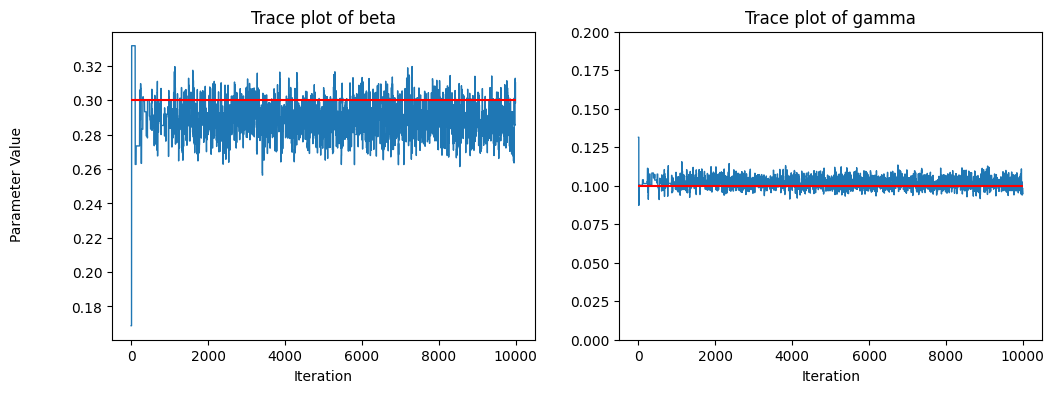

In [126]:
trace_plot(samples_adaptive)

This gives an acceptance rate $\approx 0.3$, as expected from [[4]](https://doi.org/10.1214/10-STS327):

In [127]:
acc_rate_adaptive = np.sum(results_adaptive.is_accepted)/num_iterations
acc_rate_adaptive

0.3115

and if we compute the ESS, we find that it is much higher for both $\beta$ and $\gamma$ than for any of the fixed proposal variance runs:

In [128]:
ess_adaptive = tfp.mcmc.effective_sample_size(samples_adaptive)
print(ess_adaptive)

StructTuple(
  beta=<tf.Tensor: shape=(), dtype=float32, numpy=651.8208>,
  gamma=<tf.Tensor: shape=(), dtype=float32, numpy=1297.7389>
)
